In [2]:
from cudnn_convolution import *
import scipy
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [3]:
conv_method = CudnnConvFwdAlgo.CUDNN_CONVOLUTION_FWD_ALGO_GEMM
input  = torch.from_numpy(np.array(range(25))).type(torch.float32).reshape((1, 1, 5, 5)).to('cuda')
weight = torch.ones((1, 1, 2, 2)).type(torch.float32).to('cuda')
output = cudnn_convolution_fwd(conv_method, input, weight, padding=1, verbose=True)

Using /home/yppatel/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/yppatel/.cache/torch_extensions/py311_cu121/cudnn_convolution/build.ninja...
Building extension module cudnn_convolution...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cudnn_convolution...


ninja: no work to do.
cudnn_convolution.py: Cpp Extension Compiled and Loaded!
Attempt with defined Algo:
FWD Algorithm: CUDNN_CONVOLUTION_FWD_ALGO_GEMM
	Status: CUDNN_STATUS_SUCCESS
	Time: -1
	Memory: 0
	Determinism: 
	MathType: CUDNN_DEFAULT_MATH

Allocating Workspace
Workspace size:  (0 Bytes)
Allocated size:  (0 Bytes)


Underfined Value: -1

In [4]:
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, num_channels, modes1=12, modes2=12, width=20, initial_step=10):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x, y, c)
        output: the solution of the next timestep
        output shape: (batchsize, x, y, c)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(initial_step*num_channels+2, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, num_channels)

    def forward(self, x, grid):
        # x dim = [b, x1, x2, t*v]
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # Pad tensor with boundary condition
        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding] # Unpad the tensor
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x.unsqueeze(-2)

In [5]:

import torch
from torch.utils.data import Dataset, IterableDataset
from torch.utils.data import DataLoader
import os
import glob
import h5py
import numpy as np
import math as mt

class FNODatasetSingle(Dataset):
    def __init__(self, filename,
                 initial_step=10,
                 saved_folder='./',
                 reduced_resolution=1,
                 reduced_resolution_t=1,
                 reduced_batch=1,
                 if_test=False,
                 test_ratio=0.1,
                 num_samples_max = -1
                 ):
        """
        
        :param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """
        
        # Define path to files
        root_path = os.path.join(os.path.abspath(saved_folder), filename)
        if filename[-2:] != 'h5':
            print(f".HDF5 file extension is assumed hereafter")
        
            with h5py.File(root_path, 'r') as f:
                keys = list(f.keys())
                keys.sort()
                if 'tensor' not in keys:
                    _data = np.array(f['density'], dtype=np.float32)  # batch, time, x,...
                    idx_cfd = _data.shape
                    if len(idx_cfd)==3:  # 1D
                        self.data = np.zeros([idx_cfd[0]//reduced_batch,
                                              idx_cfd[2]//reduced_resolution,
                                              mt.ceil(idx_cfd[1]/reduced_resolution_t),
                                              3],
                                            dtype=np.float32)
                        #density
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[...,0] = _data   # batch, x, t, ch
                        # pressure
                        _data = np.array(f['pressure'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[...,1] = _data   # batch, x, t, ch
                        # Vx
                        _data = np.array(f['Vx'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[...,2] = _data   # batch, x, t, ch

                        self.grid = np.array(f["x-coordinate"], dtype=np.float32)
                        self.grid = torch.tensor(self.grid[::reduced_resolution], dtype=torch.float).unsqueeze(-1)
                        print(self.data.shape)
                    if len(idx_cfd)==4:  # 2D
                        self.data = np.zeros([idx_cfd[0]//reduced_batch,
                                              idx_cfd[2]//reduced_resolution,
                                              idx_cfd[3]//reduced_resolution,
                                              mt.ceil(idx_cfd[1]/reduced_resolution_t),
                                              4],
                                             dtype=np.float32)
                        # density
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[...,0] = _data   # batch, x, t, ch
                        # pressure
                        _data = np.array(f['pressure'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[...,1] = _data   # batch, x, t, ch
                        # Vx
                        _data = np.array(f['Vx'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[...,2] = _data   # batch, x, t, ch
                        # Vy
                        _data = np.array(f['Vy'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[...,3] = _data   # batch, x, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing='ij')
                        self.grid = torch.stack((X, Y), axis=-1)[::reduced_resolution, ::reduced_resolution]
                
                    if len(idx_cfd)==5:  # 3D
                        self.data = np.zeros([idx_cfd[0]//reduced_batch,
                                              idx_cfd[2]//reduced_resolution,
                                              idx_cfd[3]//reduced_resolution,
                                              idx_cfd[4]//reduced_resolution,
                                              mt.ceil(idx_cfd[1]/reduced_resolution_t),
                                              5],
                                             dtype=np.float32)
                        # density
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[...,0] = _data   # batch, x, t, ch
                        # pressure
                        _data = np.array(f['pressure'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[...,1] = _data   # batch, x, t, ch
                        # Vx
                        _data = np.array(f['Vx'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[...,2] = _data   # batch, x, t, ch
                        # Vy
                        _data = np.array(f['Vy'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[...,3] = _data   # batch, x, t, ch
                        # Vz
                        _data = np.array(f['Vz'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[...,4] = _data   # batch, x, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        z = np.array(f["z-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        z = torch.tensor(z, dtype=torch.float)
                        X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
                        self.grid = torch.stack((X, Y, Z), axis=-1)[::reduced_resolution,\
                                                                    ::reduced_resolution,\
                                                                    ::reduced_resolution]
                                                                    
                else:  # scalar equations
                    ## data dim = [t, x1, ..., xd, v]
                    _data = np.array(f['tensor'], dtype=np.float32)  # batch, time, x,...
                    if len(_data.shape) == 3:  # 1D
                        _data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data = _data[:, :, :, None]  # batch, x, t, ch

                        self.grid = np.array(f["x-coordinate"], dtype=np.float32)
                        self.grid = torch.tensor(self.grid[::reduced_resolution], dtype=torch.float).unsqueeze(-1)
                    if len(_data.shape) == 4:  # 2D Darcy flow
                        # u: label
                        _data = _data[::reduced_batch,:,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        #if _data.shape[-1]==1:  # if nt==1
                        #    _data = np.tile(_data, (1, 1, 1, 2))
                        self.data = _data
                        # nu: input
                        _data = np.array(f['nu'], dtype=np.float32)  # batch, time, x,...
                        _data = _data[::reduced_batch, None,::reduced_resolution,::reduced_resolution]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        self.data = np.concatenate([_data, self.data], axis=-1)
                        self.data = self.data[:, :, :, :, None]  # batch, x, y, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing='ij')
                        self.grid = torch.stack((X, Y), axis=-1)[::reduced_resolution, ::reduced_resolution]

        elif filename[-2:] == 'h5':  # SWE-2D (RDB)
            print(f".H5 file extension is assumed hereafter")
        
            with h5py.File(root_path, 'r') as f:
                keys = list(f.keys())
                keys.sort()
                data_arrays = [np.array(f[key]['data'], dtype=np.float32) for key in keys]
                _data = torch.from_numpy(np.stack(data_arrays, axis=0))   # [batch, nt, nx, ny, nc]
                _data = _data[::reduced_batch, ::reduced_resolution_t, ::reduced_resolution, ::reduced_resolution, ...]
                _data = torch.permute(_data, (0, 2, 3, 1, 4))   # [batch, nx, ny, nt, nc]
                gridx, gridy = np.array(f['0023']['grid']['x'], dtype=np.float32), np.array(f['0023']['grid']['y'], dtype=np.float32)
                mgridX, mgridY = np.meshgrid(gridx, gridy, indexing='ij')
                _grid = torch.stack((torch.from_numpy(mgridX), torch.from_numpy(mgridY)), axis=-1)
                grid = _grid[::reduced_resolution, ::reduced_resolution, ...]
                _tsteps_t = torch.from_numpy(np.array(f['0023']['grid']['t'], dtype=np.float32))
                tsteps_t = _tsteps_t[::reduced_resolution_t]
                self.data = _data
                self.grid = _grid
                self.tsteps_t = tsteps_t

        if num_samples_max>0:
            num_samples_max  = min(num_samples_max, self.data.shape[0])
        else:
            num_samples_max = self.data.shape[0]

        test_idx = int(num_samples_max * test_ratio)
        if if_test:
            self.data = self.data[:test_idx]
        else:
            self.data = self.data[test_idx:num_samples_max]

        # Time steps used as initial conditions
        self.initial_step = initial_step

        self.data = self.data if torch.is_tensor(self.data) else torch.tensor(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return self.data[idx,...,:self.initial_step,:], self.data[idx], self.grid

In [6]:
pde = "2D_DarcyFlow_beta10.0_Train"

train_data = FNODatasetSingle(filename=f"{pde}.hdf5")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1)

.HDF5 file extension is assumed hereafter


In [11]:
class WNO2d(FNO2d):
    def __init__(self, num_channels, modes1=12, modes2=12, width=20, initial_step=10):
        super(WNO2d, self).__init__(num_channels, modes1, modes2, width, initial_step)

    def forward(self, x, grid):
        # x dim = [b, x1, x2, t*v]
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # Pad tensor with boundary condition
        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)

        # weight = torch.from_numpy(self.w0.weight.cpu().detach().numpy()).to('cuda')
        # weight = torch.from_numpy(weight[::-1,::-1,:,:].copy()).to("cuda")
        # print(self.w0.weight[::-1, ::-1])
        # x2 = cudnn_convolution_fwd(conv_method, x, self.w0.weight) + self.w0.bias[:, None, None]
        
        x2 = F.conv2d(x, self.w0.weight) + self.w1.bias[:, None, None]
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = F.conv2d(x, self.w1.weight) + self.w1.bias[:, None, None]
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = F.conv2d(x, self.w2.weight) + self.w2.bias[:, None, None]
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = F.conv2d(x, self.w3.weight) + self.w3.bias[:, None, None]
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding] # Unpad the tensor
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x.unsqueeze(-2)

In [12]:
initial_step = 1
model_weights = torch.load(f"{pde}_FNO.pt")
fno = WNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=initial_step).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [13]:
device  = "cuda"
t_train = 2  # this right?
for xx, yy, grid in train_loader:
    # xx: input tensor (first few time steps) [b, x1, ..., xd, t_init, v]
    # yy: target tensor [b, x1, ..., xd, t, v]
    # grid: meshgrid [b, x1, ..., xd, dims]
    xx = xx.to(device)
    yy = yy.to(device)
    grid = grid.to(device)

    x    = xx[..., 0 , :]
    y    = yy[..., t_train-1:t_train, :]
    yhat = fno(x, grid)
    break

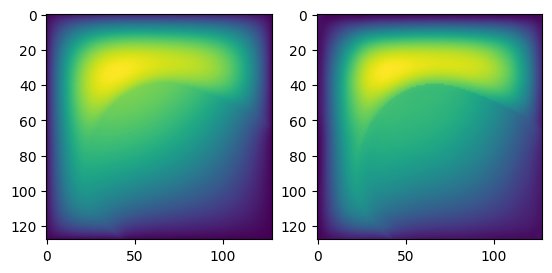

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(y.cpu().detach().numpy()[0,:,:,0,0])
ax2.imshow(yhat.cpu().detach().numpy()[0,:,:,0,0])